In [31]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

%matplotlib inline

Set our random seed so that all computations are deterministic

In [32]:
seed = 21899

Read in the raw data for the first 100K records of the HCEPDB into a pandas dataframe

In [33]:
df = pd.read_csv('https://github.com/UWDIRECT/UWDIRECT.github.io/blob/master/Wi18_content/DSMCER/HCEPD_100K.csv?raw=true')
df.head()

,id,SMILES_str,stoich_str,mass,pce,voc,jsc,e_homo_alpha,e_gap_alpha,e_lumo_alpha,tmp_smiles_str
0,655365,C1C=CC=C1c1cc2[se]c3c4occc4c4nsnc4c3c2cn1,C18H9N3OSSe,394.3151,5.161953,0.867601,91.567575,-5.467601,2.022944,-3.444656,C1=CC=C(C1)c1cc2[se]c3c4occc4c4nsnc4c3c2cn1
1,1245190,C1C=CC=C1c1cc2[se]c3c(ncc4ccccc34)c2c2=C[SiH2]...,C22H15NSeSi,400.4135,5.261398,0.504824,160.401549,-5.104824,1.630750,-3.474074,C1=CC=C(C1)c1cc2[se]c3c(ncc4ccccc34)c2c2=C[SiH...
2,21847,C1C=c2ccc3c4c[nH]cc4c4c5[SiH2]C(=Cc5oc4c3c2=C1...,C24H17NOSi,363.4903,0.000000,0.000000,197.474780,-4.539526,1.462158,-3.077368,C1=CC=C(C1)C1=Cc2oc3c(c2[SiH2]1)c1c[nH]cc1c1cc...
3,65553,[SiH2]1C=CC2=C1C=C([SiH2]2)C1=Cc2[se]ccc2[SiH2]1,C12H12SeSi3,319.4448,6.138294,0.630274,149.887545,-5.230274,1.682250,-3.548025,C1=CC2=C([SiH2]1)C=C([SiH2]2)C1=Cc2[se]ccc2[Si...
4,720918,C1C=c2c3ccsc3c3[se]c4cc(oc4c3c2=C1)C1=CC=CC1,C20H12OSSe,379.3398,1.991366,0.242119,126.581347,-4.842119,1.809439,-3.032680,C1=CC=C(C1)c1cc2[se]c3c4sccc4c4=CCC=c4c3c2o1


Separate out the predictors from the output


In [34]:
X = df[['mass', 'voc', 'jsc', 'e_homo_alpha', 'e_gap_alpha', 
        'e_lumo_alpha']].values
Y = df[['pce']].values

Let's create the test / train split for these data using 80/20.  The `_pn` extension is related to the 'prenormalization' nature of the data.

In [48]:
X_train_pn, X_test_pn, y_train_pn, y_test_pn = train_test_split(X, Y,
                                                    test_size=0.20,
                                                    random_state=seed)

Now we need to `StandardScaler` the training data and apply that scale to the test data.

In [50]:
# create the scaler from the training data only and keep it for later use
X_train_scaler = StandardScaler().fit(X_train_pn)
# apply the scaler transform to the training data
X_train = X_train_scaler.transform(X_train_pn)

Now let's reuse that scaler transform on the test set.  This way we never contaminate the test data with the training data.  We'll start with a histogram of the testing data just to prove to ourselves it is working.

(array([1293., 2369., 3874., 4430., 3822., 2618., 1159.,  359.,   70.,
           6.]),
 array([0.        , 0.15980339, 0.31960678, 0.47941017, 0.63921356,
        0.79901695, 0.95882034, 1.11862374, 1.27842713, 1.43823052,
        1.59803391]),
 <a list of 10 Patch objects>)

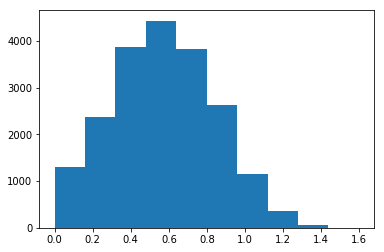

In [72]:
plt.hist(X_test_pn[:,1])

OK, bnow apply the training scaler transform to the test and plot a histogram

In [73]:
X_test = X_train_scaler.transform(X_test_pn)

(array([1293., 2369., 3874., 4430., 3822., 2618., 1159.,  359.,   70.,
           6.]),
 array([-2.12748913, -1.53607743, -0.94466574, -0.35325404,  0.23815766,
         0.82956935,  1.42098105,  2.01239275,  2.60380444,  3.19521614,
         3.78662784]),
 <a list of 10 Patch objects>)

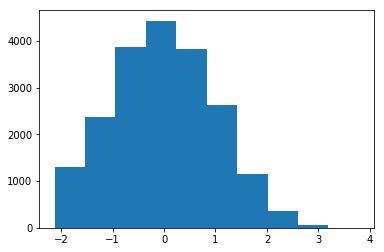

In [74]:
plt.hist(X_test[:,1])

### Let's create the neural network layout

This is a simple neural network with no hidden layers and just the inputs transitioned to the output.

In [75]:
def simple_model():
    # assemble the structure
    model = Sequential()
    model.add(Dense(6, input_dim=6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

Train the neural network with the following

In [76]:
# initialize the andom seed as this is used to generate
# the starting weights
np.random.seed(seed)
# create the NN framework
estimator = KerasRegressor(build_fn=simple_model,
        epochs=150, batch_size=25000, verbose=0)
history = estimator.fit(X_train, y_train, validation_split=0.33, epochs=150, 
        batch_size=10000, verbose=0)

The history object returned by the `fit` call contains the information in a fitting run.

In [77]:
print(history.history.keys())

dict_keys(['val_loss', 'loss'])


In [78]:
print("final MSE for train is %.2f and for validation is %.2f" % 
      (history.history['loss'][-1], history.history['val_loss'][-1]))

final MSE for train is 0.98 and for validation is 0.98


Let's plot it!

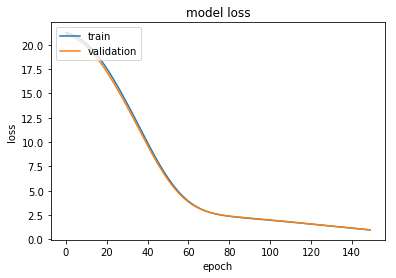

In [79]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Let's get the MSE for the test set.

In [80]:
test_loss = estimator.model.evaluate(X_test, y_test)
print("test set mse is %.2f" % test_loss)

20000/20000 [==============================] - 0s 17us/step
test set mse is 0.98


## NEAT!

So our train mse is very similar to the training and validation at the final step!

###  Let's look at another way to evaluate the set of models using cross validation

Use 10 fold cross validation to evaluate the models generated from our training set.  We'll use scikit-learn's tools for this.  Remember, this is only assessing our training set.

In [ ]:
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

#### Quick aside, `Pipeline`

Let's use scikit learns `Pipeline` workflow to run a k-fold cross validation run on the learned model.

With this tool, we create a workflow using the `Pipeline` object.  You provide a list of actions (as named tuples) to be performed.  We do this with `StandardScaler` to eliminate the posibility of training leakage into the test set during normalization.

In [ ]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=simple_model,
        epochs=1000, batch_size=25000, verbose=1)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X_train, Y_train, cv=kfold)
print('MSE mean: %.4f ; std: %.4f' % (results.mean(), results.std()))